In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import copy
import random

In [28]:
game_theory_rewards = [[[3, 3], [5, 0]],
                       [[0, 5], [1, 1]]]

print(pd.DataFrame(game_theory_rewards, columns = ['Player 1 Cooperates', 'Player 1 Defects'], index = ['Player 2 Cooperates', 'Player 2 Defects']))

                    Player 1 Cooperates Player 1 Defects
Player 2 Cooperates              [3, 3]           [5, 0]
Player 2 Defects                 [0, 5]           [1, 1]


In [29]:
def play_game(p1_move, p2_move, reward_matrix = game_theory_rewards):
    outcome_p1, outcome_p2 = reward_matrix[p2_move][p1_move]

    return outcome_p1, outcome_p2

play_game(1,0)

(5, 0)

In [111]:
#create player classes
class Player():
    def __init__(self, player_id, time_step = 0):
        self.player_id = player_id
        self.score = 0
        self.offspring = 0
        self.learning_rate = 0.1
        self.time_step = time_step
        self.history = {}#{self.time_step:self.score}
        self.age = 0

        self.chromosome = {'memory': 2, 
                            'bias': np.random.randn(),
                            'input_weights': np.random.randn(2)}

    def play(self, game_history):
        game_history = np.array(game_history)
        #replace 0s with -1
        game_history[game_history == 0] = -1

        #truncate history
        if len(game_history) > self.chromosome['memory']:
            input = game_history[:self.chromosome['memory']]
        elif len(game_history) < self.chromosome['memory']:
            start_array = np.zeros(self.chromosome['memory'] - len(game_history))
            input = np.concatenate([start_array, game_history])
        else:
            input = game_history
        
        # print(len(input), self.chromosome['memory'])
        assert len(input) == self.chromosome['memory']
        #think
        output = np.dot(input, self.chromosome['input_weights']) + self.chromosome['bias']

        if output > 0:
            #split
            output = 1
        else:
            #steal
            output = 0
        
        return output

    def update_score_and_step(self, result):
        self.score += result
        self.history[self.time_step] = self.score
        self.time_step += 1
        self.age+=1

    def mutate(self, mutate_memory = True):
        #mutate memory
        if mutate_memory:
            mutation = np.random.randint(0, 3) - 1
            self.chromosome['memory'] = int(self.chromosome['memory'] + mutation)
            #check chromosome for length change
            if len(self.chromosome['input_weights']) > self.chromosome['memory']:
                #truncate chromosome
                self.chromosome['input_weights'] = self.chromosome['input_weights'][:self.chromosome['memory']]
            elif len(self.chromosome['input_weights']) < self.chromosome['memory']:
                #extend chromosome
                self.chromosome['input_weights'] = np.append(self.chromosome['input_weights'], 0)

        #mutate bias
        mutation = np.random.randn()*self.learning_rate
        self.chromosome['bias'] = self.chromosome['bias'] + mutation
        
        #mutate chromosome
        mutation = np.random.randn(len(self.chromosome['input_weights']))*self.learning_rate
        self.chromosome['input_weights'] = self.chromosome['input_weights'] + mutation
    
    # def update_identity(self, tag):
    #     self.player_id = self.player_id + tag
    #     self.score = 0
    #     self.history


In [112]:
p1 = Player('A')

print(p1.chromosome)
p1.mutate()
print(p1.chromosome)

{'memory': 2, 'bias': 1.6663975842967917, 'input_weights': array([ 0.29886878, -0.65983816])}
{'memory': 1, 'bias': 1.7118635875270323, 'input_weights': array([0.31322627])}


In [113]:
for i in range(10):
    print(np.random.randint(0,3) - 1)

0
0
1
0
0
1
-1
1
-1
-1


In [114]:
p2 = copy.deepcopy(p1)

p2.chromosome['input_bias'] = 1


print(p1.chromosome)
print(p2.chromosome)

{'memory': 1, 'bias': 1.7118635875270323, 'input_weights': array([0.31322627])}
{'memory': 1, 'bias': 1.7118635875270323, 'input_weights': array([0.31322627]), 'input_bias': 1}


In [115]:
pA = Player(player_id='A')
pB = Player(player_id='B')

game_history_A = []
game_history_B = []


for i in range(10):
    pA_move = pA.play(game_history_A)
    pB_move = pB.play(game_history_B)
    print(i, pA_move, pB_move)

    game_history_A.append(pB_move)
    game_history_B.append(pA_move)

    

0 0 0
1 0 0
2 1 0
3 1 0
4 1 0
5 1 0
6 1 0
7 1 0
8 1 0
9 1 0


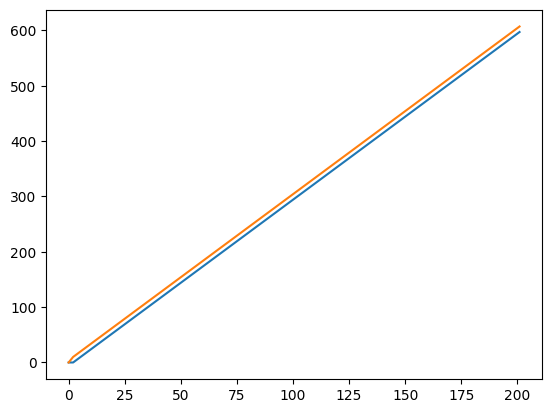

In [116]:
def play_n_games(p1, p2, reward_matrix = game_theory_rewards, n = 200, random_noise = 10, print_logs = False):
    """
    play n games between p1 and p2. n can be randomly selected to avoid strategies that abuse knowing
    the when the final game is, e.g. always stealing on the final game.
    """
    if random_noise > 0:
        #generate random noise, normal distribution with mean = 0 and variance = random_noise
        noise = np.random.randn()*random_noise
        n = n + int(noise)

    p1_score_history = [0]
    p2_score_history = [0]

    game_history_p1 = []
    game_history_p2 = []

    #simulate
    for i in range(n):
        p1_move = pA.play(game_history_p1)
        p2_move = pB.play(game_history_p2)
        if print_logs:
            print(i, p1_move, p2_move)

        #log moves
        game_history_p1.append(p2_move)
        game_history_p2.append(p1_move)

        #compute rewards
        outcome_p1, outcome_p2 = reward_matrix[p2_move][p1_move]
        p1_score_history.append(p1_score_history[-1] + outcome_p1)
        p2_score_history.append(p2_score_history[-1] + outcome_p2)

    #update score and cost
    p1.update_score_and_step(p1_score_history[-1])
    p2.update_score_and_step(p2_score_history[-1])
    return p1_score_history, p2_score_history, game_history_p1, game_history_p2
        

pA = Player(player_id='A')
pB = Player(player_id='B')

p1_score_history, p2_score_history, game_history_p1, game_history_p2 = play_n_games(pA, pB)

plt.plot(p1_score_history, label = 'p1')
plt.plot(p2_score_history, label = 'p2')

In [117]:
def match_players(p_list):
    assert len(p_list) % 2 == 0
    
    random.shuffle(p_list)

    p1s = p_list[:int(len(p_list)/2)]
    p2s = p_list[int(len(p_list)/2):]

    return p1s, p2s


match_players(['A', 'B', 'C', 'D', 'E', 'F'])

(['D', 'F', 'B'], ['E', 'A', 'C'])

Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900


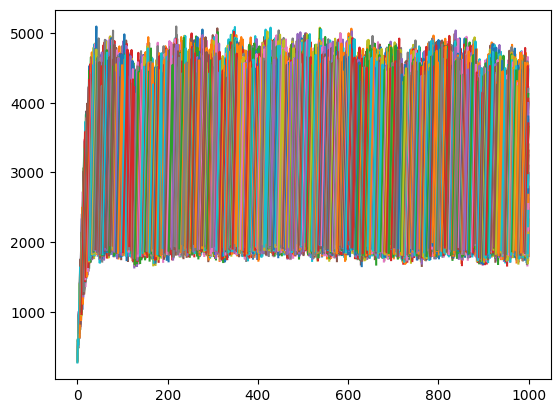

In [129]:
def run_simulation(num_iterations = 100, max_players = 64, n_games = 200, top_n_mutate = 5):
    #initialise starting players
    player_ids = ['pA', 'pB', 'pC', 'pD', 'pE', 'pF', 'pG', 'pH', 'pI', 'pJ']
    players = {}
    for id in player_ids:
        players[id] = Player(player_id=id)

    #active players dictionary is a copy of players dictionary to avoid pass by reference issues.
    active_players = players.copy()
    
    #iterate
    for it in range(num_iterations):
        if it%100 == 0:
            print('Iteration:', it)
        #match_players
        p1s, p2s = match_players(list(active_players.keys()))

        for p1_name, p2_name in zip(p1s, p2s):
            p1 = active_players[p1_name]
            p2 = active_players[p2_name]

            p1_score_history, p2_score_history, game_history_p1, game_history_p2 = play_n_games(p1, p2, n = n_games)

        #mutate top n players

        #get_player_scores:
        scores = {}
        top_players = []
        for player_name, player in active_players.items():
            scores[player_name] = player.score

        for i in range(top_n_mutate):
                highest_player = max(scores, key = scores.get)
                top_players.append(highest_player)
                scores.pop(highest_player)

        new_players = {}
        for player_name in top_players:
            player = players[player_name]
            child1_name = f'{player_name}B'
            child2_name = f'{player_name}C'
            c1 = Player(player_id = child1_name)
            c2 = Player(player_id = child2_name)

            #evolve child1
            c1.chromosome = player.chromosome
            c1.time_step = player.time_step
            c1.mutate()
            c1.score = player.score/3

            #evolve child2
            c2.chromosome = player.chromosome
            c2.time_step = player.time_step
            c2.mutate()
            c2.score = player.score/3

            #evolve parent
            player.player_id = f'{player_name}A'
            player.score = player.score/3

            #record new players
            new_players[child1_name] = c1
            new_players[child2_name] = c2

        #add new players
        active_players.update(new_players)
        players.update(new_players)

        #eliminate weakest players
        if len(active_players) > max_players:
            surplus = len(active_players) - max_players

            # sort and eliminate players
            for i in range(surplus):
                lowest_player = min(scores, key = scores.get)
                scores.pop(lowest_player)
                active_players.pop(lowest_player)

    
    # for player_name, player in players.items():
    #     print(player_name, player.score)
    #     plt.plot


    return players

players = run_simulation(num_iterations = 1000, n_games=100)  

for player_name, player in players.items():
    times = player.history.keys()
    scores = player.history.values()
    plt.plot(times, scores)

In [130]:
scores = {}
ages = {}

for player_name, player in players.items():
    scores[player_name] = player.score
    ages[player_name] = player.age

scores_df = pd.DataFrame(scores.values(), index=scores.keys(), columns = ['Score'])
scores_df['Age'] = ages.values()

scores_df.sort_values('Score', ascending = False)

,Score,Age
pEBBCBCBCCBBCBBBCBBCCCBBBBBBCBBBCCCCBBBCCBCBCBCBCCBBCCCBBBBCCC,4198.762339,9
pEBBCBCBCCBBCBBBCBBCCCBBBBBBCBBBCCCCBBBCCBCBCBCBCCBBCCCCBB,4125.386481,8
pEBBCBCBCCBBCBBBCBBCCCBBBBBBCBBBCCCCBBBCCBCBCBCBCCBBCCCCBC,4057.386481,8
pEBBCBCBCCBBCBBBCBBCCCBBBBBBCBBBCCCCBBBCCBCBCBCBCCBBCCCBBBBCCB,4029.762339,9
pEBBCBCBCCBBCBBBCBBCCCBBBBBBCBBBCCCCBBBCCBCBCBCBCCBBCCCBBBBBB,4012.095672,9
...,...,...
pABB,935.259259,1
pABCB,839.814815,1
pD,795.925926,8
pAC,779.592593,0


<AxesSubplot: xlabel='Score', ylabel='Count'>

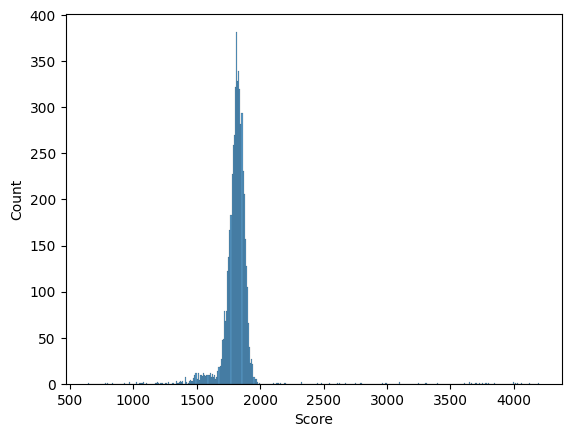

In [131]:
sns.histplot(scores_df, x = 'Score')

<AxesSubplot: xlabel='Age', ylabel='Count'>

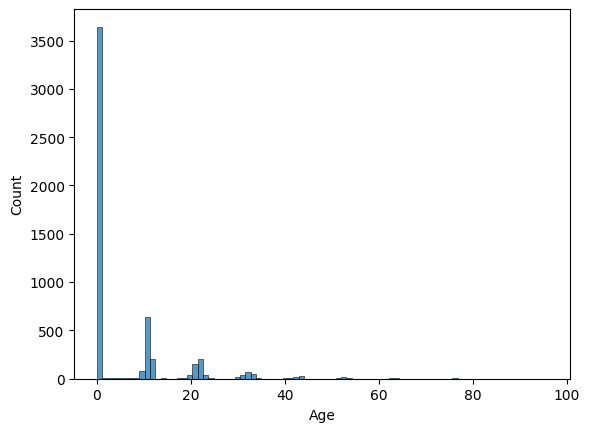

In [132]:
sns.histplot(scores_df, x = 'Age')

Iteration: 0


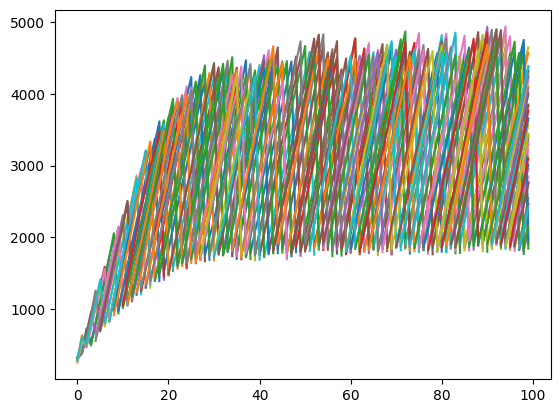

In [133]:
players2 = run_simulation(num_iterations = 100, n_games=100)  

for player_name, player in players2.items():
    times = player.history.keys()
    scores = player.history.values()
    plt.plot(times, scores)

                    Score  Age
pEBBBBCBB     4311.186884   20
pECBCCBBCCCC  4279.864694    9
pECBCCBBCCC   4244.864694   20
pEBBBBCBBB    4227.186884    9
pECBCCBBCCCB  4189.864694    9


<AxesSubplot: xlabel='Score', ylabel='Count'>

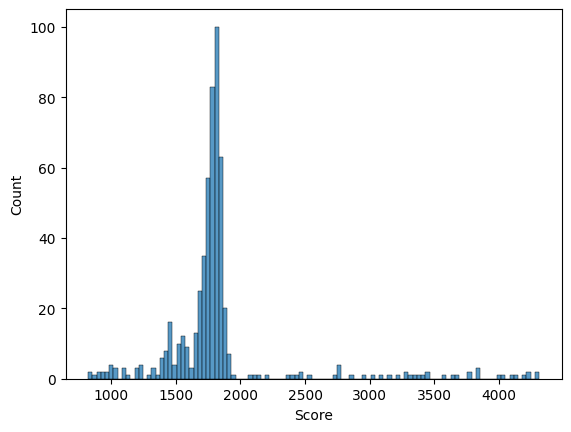

In [136]:
scores = {}
ages = {}

for player_name, player in players2.items():
    scores[player_name] = player.score
    ages[player_name] = player.age

scores_df = pd.DataFrame(scores.values(), index=scores.keys(), columns = ['Score'])
scores_df['Age'] = ages.values()

print(scores_df.sort_values('Score', ascending = False).head())

sns.histplot(scores_df['Score'])

<AxesSubplot: xlabel='Age', ylabel='Count'>

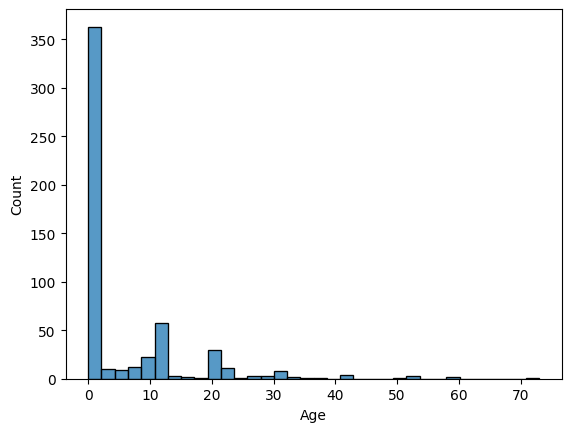

In [137]:
sns.histplot(scores_df['Age'])